In [7]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('commodities.csv')

# Display basic information about the dataset
print("Dataset Info:")
df.info()

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)

# Convert 'SourceCalendarDay' to datetime
df['SourceCalendarDay'] = pd.to_datetime(df['SourceCalendarDay'], errors='coerce')

# Drop rows with invalid or failed date conversion
df = df.dropna(subset=['SourceCalendarDay'])

# Sort data by date for time-series analysis
df = df.sort_values(by='SourceCalendarDay')

# Take Commodity Name input from the user
commodity_name = input("Enter Commodity Name: ")

# Filter data based on the selected Commodity Name
filtered_data = df[df['Commodity Name'] == commodity_name]

# Keep only 'SourceCalendarDay' and 'Modal price for the commodity' for prediction
filtered_data = filtered_data[['SourceCalendarDay', 'Modal price for the commodity']]

# Reset index after filtering
filtered_data.reset_index(drop=True, inplace=True)

# Display the filtered data
print("\nFiltered Data for Commodity:", commodity_name)
print(filtered_data.head())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4191946 entries, 0 to 4191945
Data columns (total 22 columns):
 #   Column                                         Dtype  
---  ------                                         -----  
 0   ROWID                                          int64  
 1   Country                                        object 
 2   State LGD Code                                 int64  
 3   State                                          object 
 4   District LGD Code                              int64  
 5   District                                       object 
 6   Market Name                                    object 
 7   Commodity Name                                 object 
 8   Variety of commodities                         object 
 9   Grade standard of commodity                    object 
 10  Minimum price for the commodity in the market  float64
 11  Maximum price for the commodity in the market  float64
 12  Modal price for the commodit

Enter Commodity Name:  Paddy(Dhan)(Common)



Filtered Data for Commodity: Paddy(Dhan)(Common)
  SourceCalendarDay  Modal price for the commodity
0        2016-01-01                         2150.0
1        2016-01-01                         2540.0
2        2016-01-01                         2530.0
3        2016-01-01                         2500.0
4        2016-01-01                         2450.0


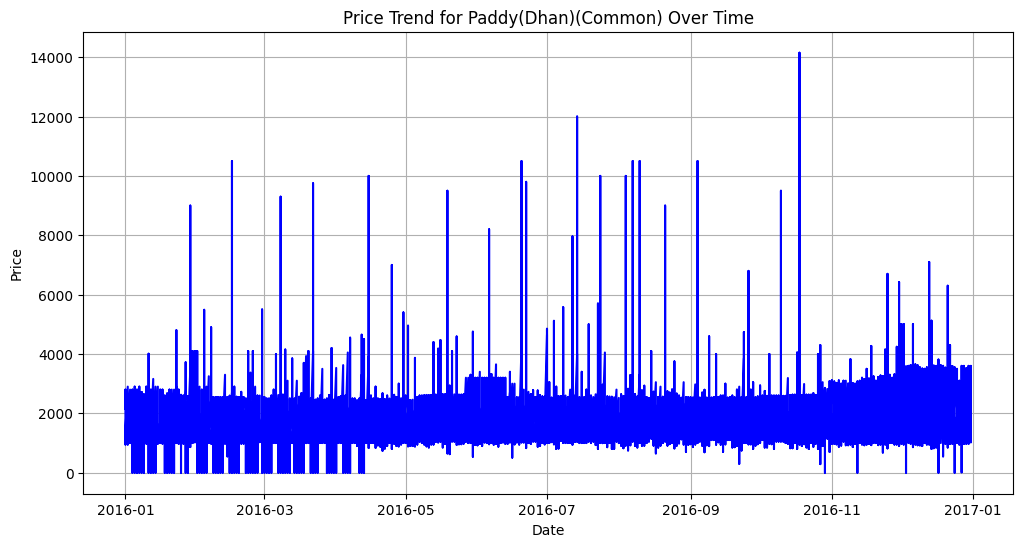

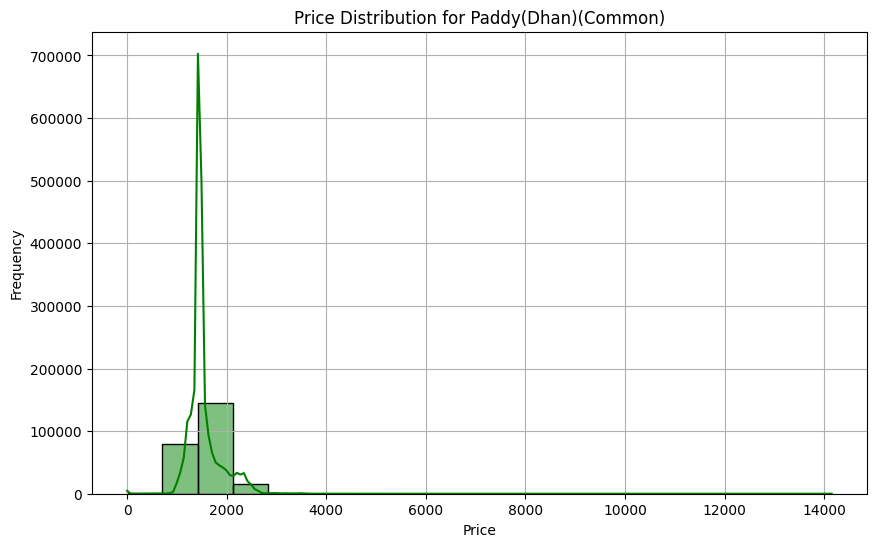


Basic Statistics for Prices:
count    242112.000000
mean       1532.386521
std         322.636378
min           0.000000
25%        1410.000000
50%        1450.000000
75%        1555.000000
max       14150.000000
Name: Modal price for the commodity, dtype: float64


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Line plot of the 'Modal price for the commodity' over time
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['SourceCalendarDay'], filtered_data['Modal price for the commodity'], color='blue')
plt.title(f"Price Trend for {commodity_name} Over Time")
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Distribution plot of the 'Modal price for the commodity'
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['Modal price for the commodity'], bins=20, kde=True, color='green')
plt.title(f"Price Distribution for {commodity_name}")
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Basic statistics for the commodity prices
print("\nBasic Statistics for Prices:")
print(filtered_data['Modal price for the commodity'].describe())


In [10]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Extract the 'Modal price for the commodity' and convert it to a NumPy array
prices = filtered_data['Modal price for the commodity'].values.reshape(-1, 1)

# Normalize the prices using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Function to create sequences for LSTM
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Create sequences with a window of 30 time steps
time_steps = 30
X, y = create_sequences(scaled_prices, time_steps)

# Reshape X to fit the LSTM model (samples, time_steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Print the shapes of the datasets
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (193665, 30, 1)
Test set shape: (48417, 30, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))  # Output layer with one neuron (predicted price)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

# Make predictions using the test set
predicted_prices = model.predict(X_test)

# Inverse scale the predicted prices back to the original price range
predicted_prices = scaler.inverse_transform(predicted_prices.reshape(-1, 1))

# Inverse scale the actual test prices
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
6053/6053 ━━━━━━━━━━━━━━━━━━━━ 217s 35ms/step - loss: 2.3028e-04
Epoch 2/20
6053/6053 ━━━━━━━━━━━━━━━━━━━━ 207s 34ms/step - loss: 1.3698e-04
Epoch 3/20
 590/6053 ━━━━━━━━━━━━━━━━━━━━ 3:08 34ms/step - loss: 2.6028e-04

In [ ]:
# Plot the actual prices vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='blue', label='Actual Prices')
plt.plot(predicted_prices, color='red', label='Predicted Prices')
plt.title(f"Actual vs Predicted Prices for {commodity_name}")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()